(182, 218, 182) torch.Size([1, 1, 182, 218, 182]) torch.Size([1, 1, 3, 182, 218, 182])
Pixel MSE Loss: 17.352642059326172
Gradient MSE Loss: 6.56171989440918


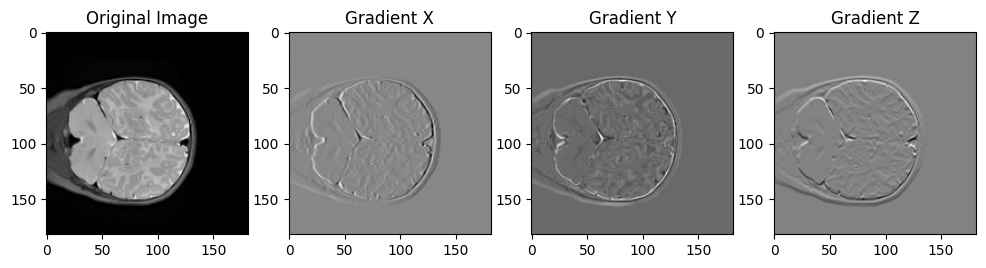

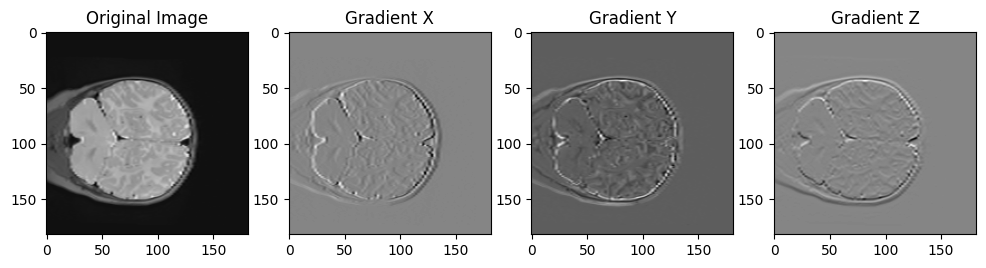

In [18]:
import kornia
import pathlib
import nibabel as nib
import matplotlib.pyplot as plt

import torch

loss_fn = torch.nn.MSELoss()

DATA_DIR = pathlib.Path.home()/"data"/"bobsrepository"
t2_files = sorted(DATA_DIR.rglob("*T2w.nii.gz"))
t2_LR_files = sorted(DATA_DIR.rglob("*T2w_LR.nii.gz"))
t2_LR4_files = sorted(DATA_DIR.rglob("*T2w_LR4.nii.gz"))

t2_img = nib.load(t2_files[0]).get_fdata()
t2_lr_img = nib.load(t2_LR_files[0]).get_fdata()
t2_lr4_img = nib.load(t2_LR4_files[0]).get_fdata()
t2_tensor = torch.tensor(t2_img).unsqueeze(0).unsqueeze(0).float()
t2_lr_tensor = torch.tensor(t2_lr_img).unsqueeze(0).unsqueeze(0).float()
t2_lr4_tensor = torch.tensor(t2_lr4_img).unsqueeze(0).unsqueeze(0).float()
gradients = kornia.filters.spatial_gradient3d(t2_tensor)
gradients_lr = kornia.filters.spatial_gradient3d(t2_lr_tensor)
gradients_lr4 = kornia.filters.spatial_gradient3d(t2_lr4_tensor)
print(t2_img.shape, t2_tensor.shape, gradients.shape)

#plot edge maps
fig = plt.figure(figsize=(12, 8))
mid_slice = t2_img.shape[2] // 2
plt.subplot(1,4,1)
plt.title("Original Image")
plt.imshow(t2_img[:,mid_slice, :], cmap='gray')
plt.subplot(1,4,2)
plt.title("Gradient X")
plt.imshow(gradients[0,0,0,:,mid_slice, :], cmap='gray')
plt.subplot(1,4,3)
plt.title("Gradient Y")
plt.imshow(gradients[0,0,1,:,mid_slice, :], cmap='gray')
plt.subplot(1,4,4)
plt.title("Gradient Z")
plt.imshow(gradients[0,0,2,:,mid_slice, :], cmap='gray')

fig = plt.figure(figsize=(12, 8))
mid_slice = t2_img.shape[2] // 2
plt.subplot(1,4,1)
plt.title("Original Image")
plt.imshow(t2_lr_img[:,mid_slice, :], cmap='gray')
plt.subplot(1,4,2)
plt.title("Gradient X")
plt.imshow(gradients_lr[0,0,0,:,mid_slice, :], cmap='gray')
plt.subplot(1,4,3)
plt.title("Gradient Y")
plt.imshow(gradients_lr[0,0,1,:,mid_slice, :], cmap='gray')
plt.subplot(1,4,4)
plt.title("Gradient Z")
plt.imshow(gradients_lr[0,0,2,:,mid_slice, :], cmap='gray')

loss = loss_fn(gradients, gradients_lr4)
loss_pix = loss_fn(t2_tensor, t2_lr4_tensor)
print("Pixel MSE Loss:", loss_pix.item())
print("Gradient MSE Loss:", loss.item())

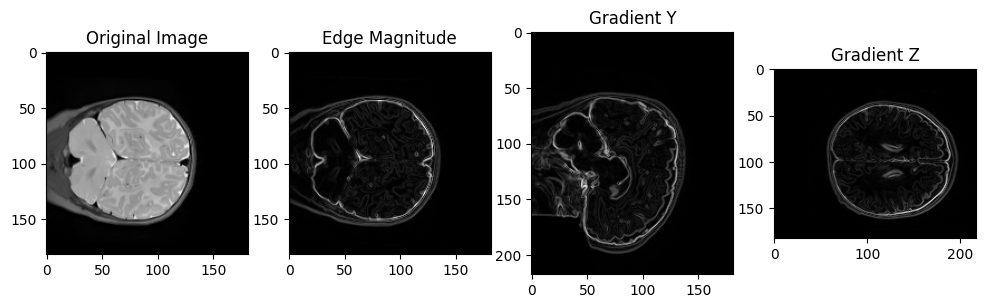

In [11]:
grad = gradients 
# shape (B, C, 3, D, H, W)

dx = grad[:, :, 0]
dy = grad[:, :, 1]
dz = grad[:, :, 2]

edge_mag = torch.sqrt(dx*dx + dy*dy + dz*dz + 1e-8)
# shape (B, C, D, H, W)

#plot for all directions
fig = plt.figure(figsize=(12, 8))
mid_slice = t2_img.shape[2] // 2
plt.subplot(1,4,1)
plt.title("Original Image")
plt.imshow(t2_img[:,mid_slice, :], cmap='gray')
plt.subplot(1,4,2)
plt.title("Edge Magnitude")
plt.imshow(edge_mag[0,0,:,mid_slice, :].detach().numpy(), cmap='gray')
plt.subplot(1,4,3)
plt.title("Gradient Y")
plt.imshow(edge_mag[0,0,mid_slice,:, :].detach().numpy(), cmap='gray')
plt.subplot(1,4,4)
plt.title("Gradient Z")
plt.imshow(edge_mag[0,0,:,:,mid_slice].detach().numpy(), cmap='gray')


In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResBlock3D(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv1 = nn.Conv3d(channels, channels, 3, padding=1)
        self.conv2 = nn.Conv3d(channels, channels, 3, padding=1)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        y = self.relu(self.conv1(x))
        y = self.conv2(y)
        return x + y

class MergeNet3D(nn.Module):
    def __init__(self, in_channels=2, num_filters=32, num_res_blocks=8):
        super().__init__()
        # First merge conv
        self.conv_in = nn.Conv3d(in_channels, num_filters, 3, padding=1)

        # Edge-only skip conv
        self.edge_conv = nn.Conv3d(1, num_filters, 3, padding=1)

        # Residual blocks
        self.resblocks = nn.Sequential(*[
            ResBlock3D(num_filters) for _ in range(num_res_blocks)
        ])

        # Final output conv
        self.conv_out = nn.Conv3d(num_filters, 1, 3, padding=1)

    def forward(self, sr, edges):
        """
        sr:     (B, 1, D, H, W)  predicted SR volume
        edges:  (B, 1, D, H, W)  ground-truth or predicted edge map
        """
        x = torch.cat([sr, edges], dim=1)      # (B,2,DHW)

        c = self.conv_in(x)                    # shallow merge
        b = self.resblocks(c)                  # deep refinement
        a = self.edge_conv(edges)              # edge skip path

        out = c + b + a                        # merge like Keras version
        out = self.conv_out(out)
        return out

mergenet = MergeNet3D()
out = mergenet(t2_lr_tensor, edge_mag)  # test forward pass
print(out.shape)


torch.Size([1, 1, 182, 218, 182])


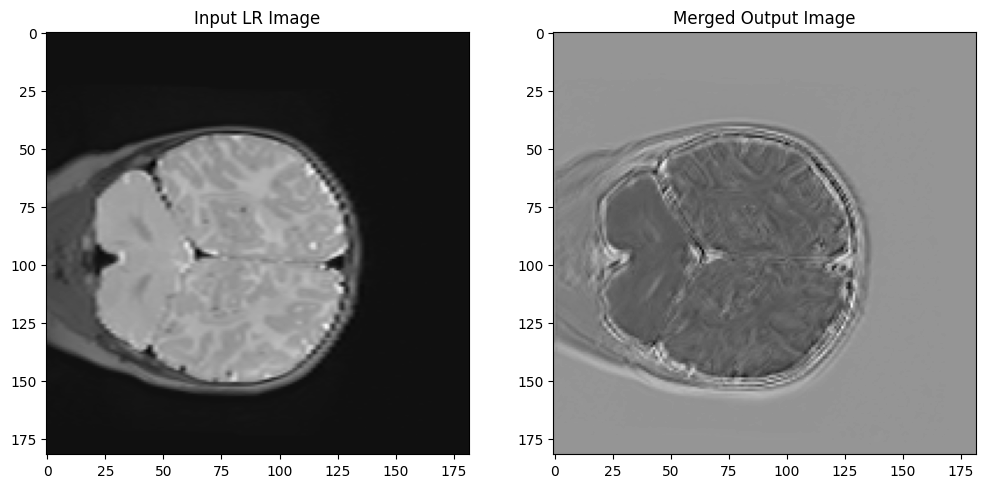

In [13]:
#plot out image
fig = plt.figure(figsize=(12, 8))
mid_slice = t2_img.shape[2] // 2
plt.subplot(1,2,1)
plt.title("Input LR Image")
plt.imshow(t2_lr_img[:,mid_slice, :], cmap='gray')
plt.subplot(1,2,2)
plt.title("Merged Output Image")
plt.imshow(out[0,0,:,mid_slice, :].detach().numpy(), cmap='gray')